# DSC 511: Project
# Argentina houses' price prediction

In [1]:
! pip install pyspark==3.4.2

In [2]:
import sys
import subprocess

subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn"])


0

In [3]:
# libraries

import sklearn
from sklearn.impute import KNNImputer
import pandas as pd
from pyspark.sql.functions import *
import seaborn as sns
import matplotlib.pyplot as plt

## Read Dataset

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# google_drive_path = "/content/gdrive/MyDrive/Colab Notebooks/Project/"

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.window import Window

# create Spark Session
spark = SparkSession.builder.appName("Project511").master("local[*]").getOrCreate()

# this is our schema defined in order for spark to read the csv correctly
schema = StructType( [
  StructField("id", StringType(), True),
  StructField("ad_type", StringType(), True),
  StructField("start_date", StringType(), True),
  StructField("end_date", StringType(), True),
  StructField("created_on", StringType(), True),
  StructField("lat", FloatType(), True),
  StructField("lon", FloatType(), True),
  StructField("l1", StringType(), True),
  StructField("l2", StringType(), True),
  StructField("l3", StringType(), True),
  StructField("l4", StringType(), True),
  StructField("l5", StringType(), True),
  StructField("l6", StringType(), True),
  StructField("rooms", IntegerType(), True),
  StructField("bedrooms", IntegerType(), True),
  StructField("bathrooms", IntegerType(), True),
  StructField("surface_total", DoubleType(), True),
  StructField("surface_covered", DoubleType(), True),
  StructField("price", DoubleType(), True),
  StructField("currency", StringType(), True),
  StructField("price_period", StringType(), True),
  StructField("title", StringType(), True),
  StructField("description", StringType(), True),
  StructField("property_type", StringType(), True),
  StructField("operation_type", StringType(), True)])

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/26 11:43:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
from pyspark.sql.functions import regexp_replace, split

# read the csv file appropriately in order to handle specific characters that are included in some of our columns
df = spark.read.format("csv").option("header", "true").option("multiLine", "true").option("escape", "\"").option("quote", "\"").schema(schema) \
    .load("/Users/andrea/Documents/MSc Data Science/2nd term/DSC 511/project/ar_properties.csv")

# clean the id column by removing HTML tags and other unwanted characters and replace new lines within the field with space
df = df.withColumn("id", regexp_replace("id", "<.*?>", "")).withColumn("id", regexp_replace("id", "[\r\n]+", " "))  

In [7]:
df.show()

+--------------------+---------+----------+----------+----------+----------+----------+---------+--------------------+--------------------+----------------+----+----+-----+--------+---------+-------------+---------------+-----+--------+------------+--------------------+--------------------+-------------+-----------------+
|                  id|  ad_type|start_date|  end_date|created_on|       lat|       lon|       l1|                  l2|                  l3|              l4|  l5|  l6|rooms|bedrooms|bathrooms|surface_total|surface_covered|price|currency|price_period|               title|         description|property_type|   operation_type|
+--------------------+---------+----------+----------+----------+----------+----------+---------+--------------------+--------------------+----------------+----+----+-----+--------+---------+-------------+---------------+-----+--------+------------+--------------------+--------------------+-------------+-----------------+
|wdQ5hWhv8P14T7Sh9...|Propie

In [8]:
df.count()

1000000

## Preprocessing

Missing Values

In [9]:
# percentage of na's in each column
na_counts = df.select([(count(when(col(c).isNull(), c)) / count('*') * 100).alias(c) for c in df.columns])

# print the results in a more readable format - in percentage
for row in na_counts.collect():
    for column, percentage in row.asDict().items():
        print(f"Percentage of NAs in {column}: {percentage:.2f}%")

24/04/26 11:44:17 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Percentage of NAs in id: 0.00%
Percentage of NAs in ad_type: 0.00%
Percentage of NAs in start_date: 0.00%
Percentage of NAs in end_date: 0.00%
Percentage of NAs in created_on: 0.00%
Percentage of NAs in lat: 15.08%
Percentage of NAs in lon: 15.17%
Percentage of NAs in l1: 0.00%
Percentage of NAs in l2: 0.00%
Percentage of NAs in l3: 5.33%
Percentage of NAs in l4: 76.05%
Percentage of NAs in l5: 99.50%
Percentage of NAs in l6: 100.00%
Percentage of NAs in rooms: 47.36%
Percentage of NAs in bedrooms: 53.38%
Percentage of NAs in bathrooms: 22.33%
Percentage of NAs in surface_total: 62.05%
Percentage of NAs in surface_covered: 61.85%
Percentage of NAs in price: 3.69%
Percentage of NAs in currency: 3.83%
Percentage of NAs in price_period: 63.70%
Percentage of NAs in title: 0.00%
Percentage of NAs in description: 0.00%
Percentage of NAs in property_type: 0.00%
Percentage of NAs in operation_type: 0.00%


### Drop Columns

In [10]:
# l4, l5, l6 refer to more specific location of the house like address, block, etc so we drop them
# we keep l1, l2, l3 which refer to the region, main locality
# drop if as it's also irrelevant

df = df.drop("l4", "l5", "l6", "id")

"ad_type" column

In [11]:

df.select('ad_type').distinct().show() #only one unique value -> drop

+---------+
|  ad_type|
+---------+
|Propiedad|
+---------+



In [12]:
df = df.drop("ad_type")

'l1' column - Country

In [13]:
# we want only houses in argentina
df.groupBy('l1').count().show()

+--------------+------+
|            l1| count|
+--------------+------+
|     Argentina|985725|
|       Uruguay| 13471|
|Estados Unidos|   705|
|        Brasil|    99|
+--------------+------+



In [14]:
# filter out any other country
df = df.filter(col("l1") == "Argentina")

'Bedrooms' Column

In [15]:
df.groupBy("bedrooms").count().sort("bedrooms").show()

+--------+------+
|bedrooms| count|
+--------+------+
|    NULL|530039|
|     -16|     1|
|      -2|     1|
|      -1|     5|
|       0| 28526|
|       1|145749|
|       2|128611|
|       3| 98326|
|       4| 38787|
|       5| 10188|
|       6|  3278|
|       7|   939|
|       8|   411|
|       9|   121|
|      10|   306|
|      11|    47|
|      12|    80|
|      13|    19|
|      14|    25|
|      15|    17|
+--------+------+
only showing top 20 rows



In [16]:
df.count()

985725

In [17]:
# [-1, -2, -16, 900, 335, 129, 100, 99]

# remove rows with bedrooms < 0 and some extreme values
df = df.filter(((col("bedrooms") >= 0) & (col("bedrooms") < 100)) | (col("bedrooms").isNull()))

In [18]:
df.count()

985691

In [19]:
# Bedrooms are larger than rooms which doesnt make sense thus we remove these rows
# we also keep the nulls
df = df.filter((col("bedrooms").isNull()) | (col("rooms").isNull()) | (col("bedrooms") <= col("rooms")))

In [20]:
df.count()

982907

### Handling missing values

In [21]:
# na of target variable = 3.69% < 10% => drop rows
df = df.na.drop(subset=["price"])

Correlation Matrix 
- search for features that might be related

In [22]:
# # get numeric columns
# numeric = [field.name for field in df.schema.fields if isinstance(field.dataType, (FloatType, IntegerType))]

# correlation_matrix = {}

# # compute correlations
# for col1 in numeric:
#     correlation_matrix[col1] = {}
#     for col2 in numeric:
#         correlation_matrix[col1][col2] = df.stat.corr(col1, col2)

# correlation_matrix_df = pd.DataFrame(correlation_matrix)

# # plot the heatmap with the correlations
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix_df, annot=True, cmap='RdBu', fmt=".2f", linewidths=.5)
# plt.title('Correlation Matrix')
# plt.show()

In [23]:
# Define an iterator to load chunks into Pandas DataFrames
def to_pandas_in_chunks(spark_df, chunk_size=1000):
    num_rows = spark_df.count()
    num_chunks = (num_rows // chunk_size) + 1
    for i in range(num_chunks):
        yield spark_df.limit(chunk_size).offset(i * chunk_size).toPandas()

# Concatenate chunks into a single Pandas DataFrame
import pandas as pd
pandas_df = pd.concat([chunk for chunk in to_pandas_in_chunks(df)], ignore_index=True)


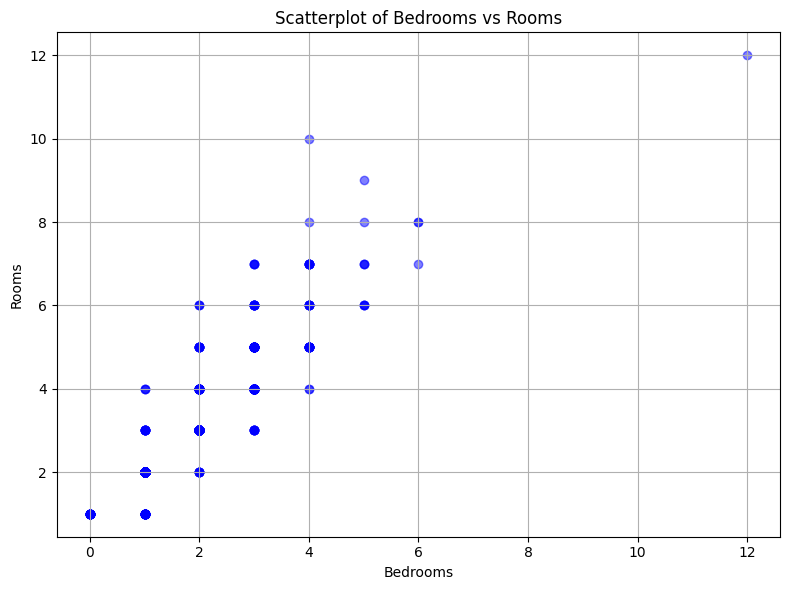

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(pandas_df['bedrooms'], pandas_df['rooms'], color='blue', alpha=0.5)
plt.title('Scatterplot of Bedrooms vs Rooms')
plt.xlabel('Bedrooms')
plt.ylabel('Rooms')
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

In [25]:
# KNNImputer
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_imputed = imputer.fit_transform(pandas_df[['bedrooms', 'rooms', 'bathrooms']]) # fit and transofmr
df_imputed = pd.DataFrame(df_imputed, columns=['bedrooms', 'rooms', 'bathrooms']) # convert the numpy array returned by the imputer to a pandas df

# # If you want to replace the original columns with imputed ones:
# pandas_df[['bedrooms', 'rooms', 'bathrooms']] = pandas_df_imputed

# # Optional: Convert back to Spark DataFrame
# spark_df_imputed = spark.createDataFrame(pandas_df)

# spark_df_imputed.show()

df_imputed.head()

,bedrooms,rooms,bathrooms
0,2.000000,4.000000,1.000000
1,2.034483,2.924577,1.541613
2,2.034483,2.924577,1.541613
3,2.034483,2.924577,1.541613
4,3.000000,4.800000,2.000000
